# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from scipy.optimize import minimize, rosen, rosen_der

In [3]:
import time

## Optimization

Optimization solves the following problem: given a scalar-valued function $f(\mathbf{x})$ defined in the multidimensional space of $\mathbf{x}$, find the value $\mathbf{x}=\mathbf{x}^\ast$ where $f(\mathbf{x})$ is minimized, or, in more formal language:
$$
\mathbf{x}^\ast = \underset{\mathbf{x}}{\mathrm{argmin}}\, f(\mathbf{x})
$$
This statement of the problem is more general that it first appears, since:
 - Minimizing $-f$ is equivalent to maximizing $f$.
 - A vector-valued function can also be optimized by defining a suitable norm, $f = |\vec{f}|$.
 - Constraints on the allowed values of $\mathbf{x}$ can be encoded in $f$ by having it return $\infty$ in illegal regions.
 
This is conceptually a straightforward problem, but efficient numerical methods are challenging, especially in high dimensions.

The simplest method is an exhaustive grid search. In 1D, this boils down to making a plot and reading off the lowest value.  For example (note the useful [np.argmin](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html)):

In [4]:
def f(x):
    return x ** 2 - 10 * np.exp(-10000 * (x - np.pi) ** 2)

min f(x) at x = 0.0


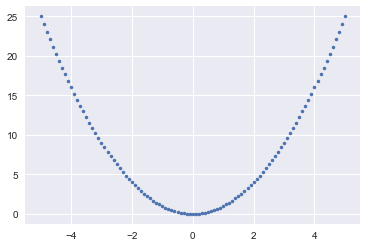

In [5]:
x = np.linspace(-5, +5, 101)
plt.plot(x, f(x), '.')
print('min f(x) at x =', x[np.argmin(f(x))])

**EXERCISE:** Study the example above and explain why it fails to find the true minimum of $f(x)$. Make a different plot that does find the true minimum.

A search using a grid with spacing $\Delta x$ can completely miss features narrower than $\Delta x$, so is only reliable when you have some prior knowledge that your $f(x)$ does not have features narrower than some limit.

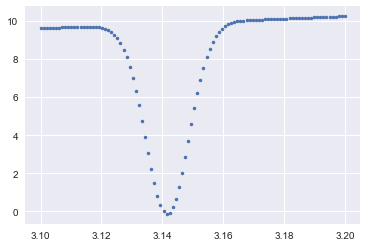

In [6]:
x = np.linspace(3.1, 3.2, 100)
plt.plot(x, f(x), '.');

The main computational cost of optimization is usually the evaluation of $f$, so an important metric for any optimizer is the number of different locations where it needs to evaluate $f$.

In $D$ dimensions, a grid search requires $f$ to be evaluated at $n^D$ different locations, which becomes prohibitive for large $D$. Fortunately, there are much better methods when $f$ satisfies two conditions:
 - It is reasonably smooth, so that local derivatives reliably point "downhill".
 - It has a single global minimum.

The general approach of these methods is to simulate a ball moving downhill until it can no further. The first condition allows us to calculate derivatives $\nabla f(\mathbf{x})$ to move downhill and to identify the minimum. The second condition is necessary to avoid getting trapped in the false minimum at $x=0$ in the example above.

We often cannot guarantee the second condition but all is not lost: the first condition still allows us to reliably find a *local minimum*, but we can never know if it is also the global minimum. A practical workaround is to simulate many balls starting from different locations and hope that at least one of them falls into the global minimum.

[Convex functions](https://en.wikipedia.org/wiki/Convex_function) are special since they are guaranteed to meet the second condition. We have already seen that the KL divergence is convex and discussed [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality) which applies to convex functions.  Convex functions are extremely important in optimization but rare in the wild: unless you know that your function has a single global minimum, you should generally assume that it has many local minima, especially in many dimensions.

Derivatives of $f(\mathbf{x})$ can either be calculated numerically, using:
$$
\frac{\partial}{\partial x_i} f(\mathbf{x}) \simeq
\frac{f(\mathbf{x} + \delta \mathbf{e}_i) - f(\mathbf{x} - \delta \mathbf{e}_i)}{2\delta} \; ,
$$
or else analytically, then coded up by hand, e.g.
```
def f(x):
    return x ** 2
def fp(x):
    return 2 * x
```
There is also a third hybrid approach that has proven very useful in machine learning, especially for training deep neural networks: [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). This requires that a small set of primitive functions (sin, cos, exp, log, ...) are handled analytically, and then composition of these primitives is handled by applying the rules of differentiation (chain rule, product rule, etc) directly to the code that evaluates `f(x)`.  We will learn more about automatic differentiation soon in the context of [tensorflow](https://www.tensorflow.org/).

## Optimization in Machine Learning

Most ML algorithms involve some sort of optimization (although MCMC sampling is an important exception). For example, the [K-means clustering algorithm](http://scikit-learn.org/stable/modules/clustering.html#k-means) minimizes
$$
\sum_{i=1}^n\, \sum_{c_j = i}\, \left| x_j - \mu_i\right|^2
$$
where $c_j = 1$ if sample $j$ is assigned to cluster $i$ or otherwise $c_j = 0$, and
$$
\mu_i = \sum_{c_j = i}\, x_j
$$
is the mean of samples assigned to cluster $i$.

Optimization is also useful in Bayesian inference. In particular, it allows us to locate the most probable point in the parameter space, known as the **maximum a-priori (MAP) point estimate**:
$$
MAP \equiv \underset{\mathbf{\theta}}{\mathrm{argmin}}\, P(\theta\mid D) \; .
$$
You can also locate the point that is most probable according to just your likelihood, known as the **maximum likelihood (ML) point estimate**:
$$
ML \equiv \underset{\mathbf{\theta}}{\mathrm{argmin}}\, P(D\mid \theta) \; .
$$
A frequentists who do not believe in priors generally focuses on ML, but MAP is the fundamental point estimate in Bayesian inference.

Note that a point estimate is not very useful on its own since it provides no information on what range of $\theta$ is consistent with the data, otherwise known as the parameter uncertainty!  Point estimates are still useful, however, to provide a good starting point for MCMC chains or when followed by an exploration of the surrounding posterior to estimate uncertainties.

Variational inference is another important application of optimization, where it allows us to find the "closest" approximating PDF $q(\theta; s)$ to the true posterior PDF $P(\theta\mid D)$ by optimizing with respect to variables $s$ that explore the family $q$.

## Optimization Libraries

The [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module implements a suite of standard general-purpose algorithms that are accessible via its `minimize()` function, e.g.
```
opt = minimize(f, [x0, y0], method='Nelder-Mead', jac=jac, tol=tol)
```
Optional derivatives are passed via `jac` (short for Jacobian) and the desired accuracy via `tol`.

For a challenging test case, we use the [Rosen function](https://en.wikipedia.org/wiki/Rosenbrock_function):

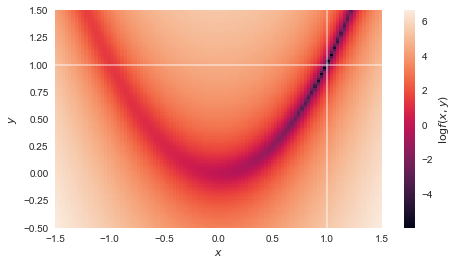

In [7]:
def plot_rosen(xrange=(-1.5, 1.5), yrange=(-0.5,1.5), n=100):
    f = np.empty((n, n))
    for i, x in enumerate(np.linspace(*xrange, n)):
        for j, y in enumerate(np.linspace(*yrange, n)):
            f[j, i] = rosen([x, y])
    fig = plt.figure(figsize=(8, 4))
    plt.imshow(np.log(f), origin='lower', extent=[*xrange, *yrange])
    plt.colorbar().set_label('$\log f(x,y)$')
    plt.axhline(1, c='w', alpha=0.5)
    plt.axvline(1, c='w', alpha=0.5)
    #plt.scatter(1, 1, marker='o', s=250, facecolor='none', edgecolor='w', lw=2)
    plt.grid('off')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    return xrange, yrange
    
plot_rosen();

This function has a curved valley with a shallow minimum at $(x,y) = (1,1)$ and steeply rising sides (hence the log color scale).

In [8]:
def optimize_rosen(method, use_derivatives=False, x0=-1, y0=0, tol=1e-4):

    # Store the optimizer's path for plotting.
    xpath, ypath = [], []
    def myrosen(xy):
        xpath.append(xy[0])
        ypath.append(xy[1])
        return rosen(xy)
    
    jac = rosen_der if use_derivatives else None
    start = time.time()
    opt = minimize(myrosen, [x0, y0], method=method, jac=jac, tol=tol)
    stop = time.time()
    
    print('Found minimum with error {} using {} calls, in {:.3f} ms.'
          .format(opt.x - np.ones(2), len(xpath), 1e3 * (stop - start)))
    
    xrange, yrange = plot_rosen()
    plt.scatter(xpath, ypath, lw=0, s=10, c='cyan')
    plt.plot(xpath, ypath, lw=1, c='cyan', alpha=0.3)
    plt.scatter(x0, y0, marker='x', s=250, c='b')
    plt.xlim(*xrange)
    plt.ylim(*yrange)

First, use the robust [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder-Mead_method) algorithm, which does need analytic derivatives to be provided:

Found minimum with error [  9.35059881e-06   1.57076290e-05] using 153 calls, in 7.175 ms.


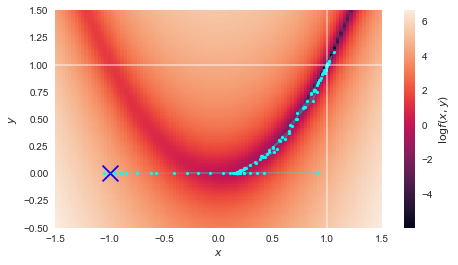

In [9]:
optimize_rosen(method='Nelder-Mead', use_derivatives=False)

In this example, we found the true minimum with an error below $10^{-4}$ in each coordinate (as requested) using only  about 150 calls to evaluate $f(x)$, but an exhaustive grid search would have required more than $10^{8}$ calls to achieve comparable accuracy!

Next try the [Powell method](https://en.wikipedia.org/wiki/Powell's_method) which is usually more efficient, but has trouble with our pathological function:

Found minimum with error [  2.22044605e-16   2.22044605e-16] using 420 calls, in 10.957 ms.


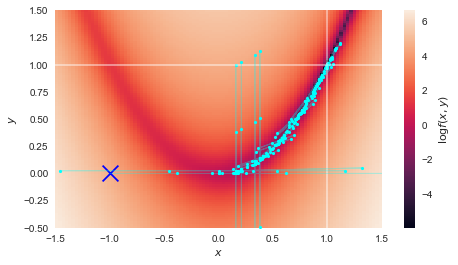

In [10]:
optimize_rosen(method='Powell')

**EXERCISE:** Try the [BFGS method](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm) with and without derivatives. What do you conclude about the benefit of using derivatives?

Found minimum with error [ -2.74573633e-06  -5.48443348e-06] using 33 calls, in 4.844 ms.


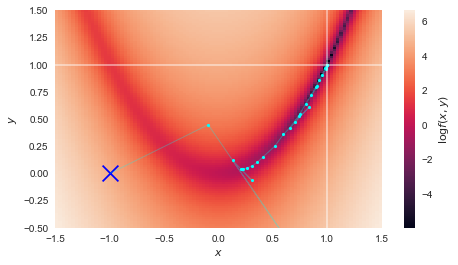

In [11]:
optimize_rosen(method='BFGS', use_derivatives=True)

Found minimum with error [ -7.21771618e-06  -1.44359166e-05] using 132 calls, in 5.561 ms.


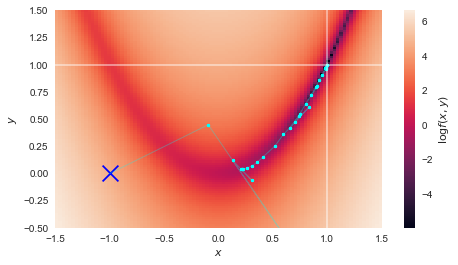

In [12]:
optimize_rosen(method='BFGS', use_derivatives=False)

The use of derivatives reduces the number of calls dramatically, with a less dramatic reduction in the running time (since we are now evaluating $f(x)$ and its two partial derivatives). The use of derivatives also achieves higher accuracy in this case.

---

Other optimization libraries that you might find useful are:
- [lmfit](http://cars9.uchicago.edu/software/python/lmfit/): a more user-friendly front-end to `scipy.optimize`.
- [minuit](https://en.wikipedia.org/wiki/MINUIT): a favorite in the particle physics community that is generally more robust and provides tools to estimate (frequentist) parameter uncertainties.

## Stochastic Optimization

In machine-learning applications, the function being optimized often involves an inner loop over data samples. For example, in Bayesian inference, this enters via the likelihood,
$$
\log P(D\mid \theta) = \sum_i \log P(x_i\mid \theta) \; ,
$$
where the $x_i$ are the individual data samples.  With a large number of samples, this iteration can be prohibitively slow, but **stochastic optimization** provides a neat solution...